# ACoC in West Antarctica plots

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cf_xarray
import cmocean as cm

In [2]:
# Import the data (names generalised to use for both comparisons)

data_1a = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan01.nc', chunks = 'auto')
data_1b = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/bottom_salinity_map_Pan01.nc', chunks = 'auto')
data_2a = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surface_velocity_map_Pan005.nc', chunks = 'auto')
data_2b = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/bottom_salinity_map_Pan005.nc', chunks = 'auto')


In [3]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [4]:
# Land and contour data
depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)
depth_1_shelf, shelf_contour_1 = shelf_mask_isobath(depth_1, 'mom6_01')

depth_2 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)
depth_2_shelf, shelf_contour_2 = shelf_mask_isobath(depth_2, 'mom6_005')

In [5]:
shelf_contour_plot_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
shelf_contour_plot_2 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

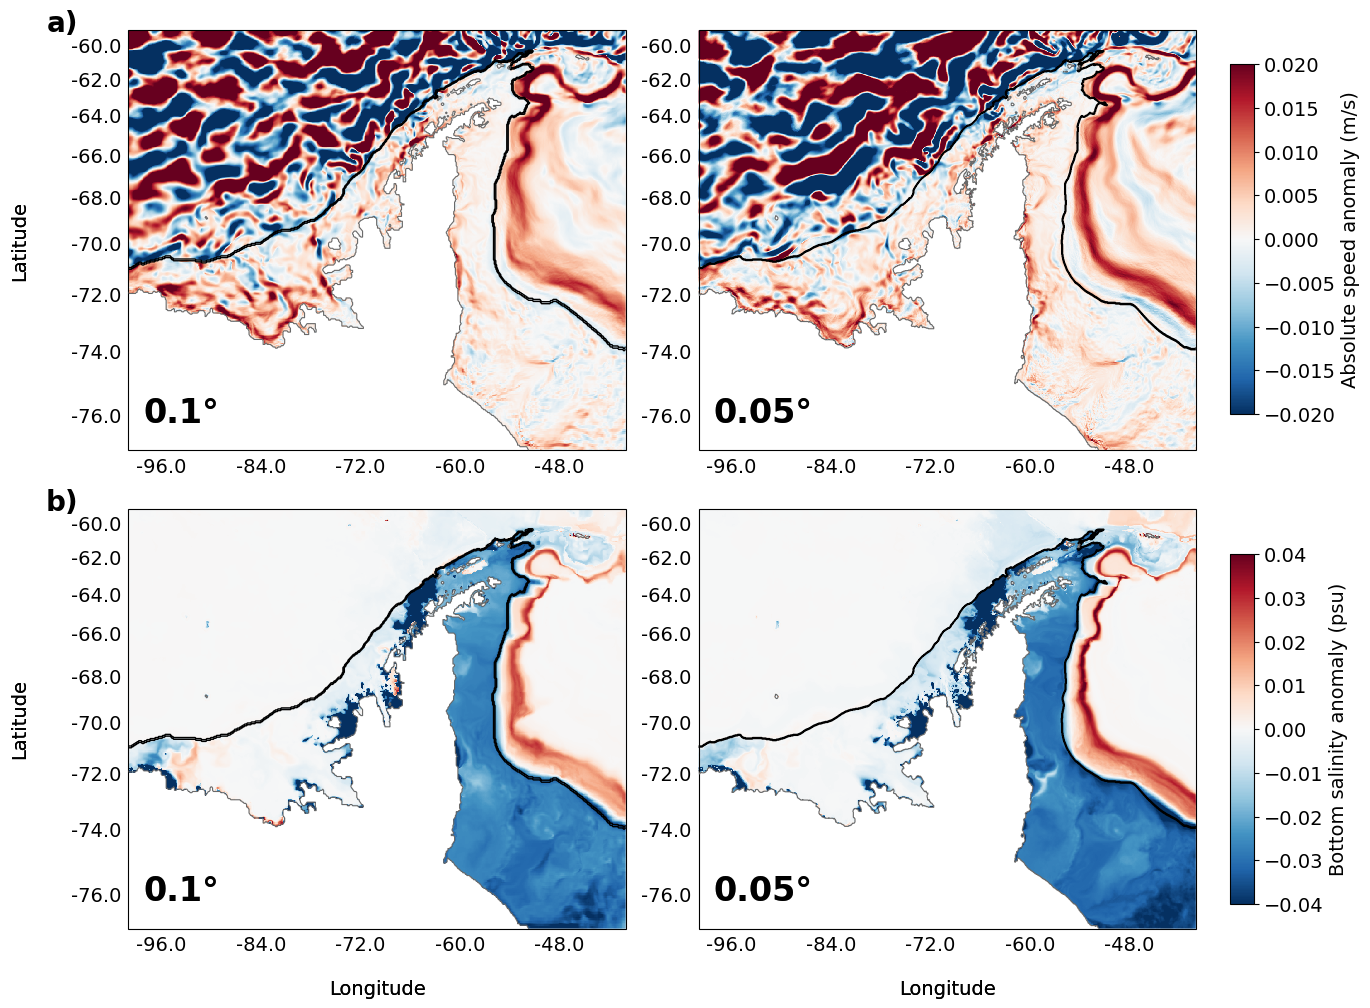

In [6]:
# --- Define region of interest (West Antarctic shelf) ---
lon_min, lon_max = -100, -40
lat_min, lat_max = -75, -59

# --- Group datasets ---
datasets = [
    [   # Row 1: surface velocity
        {
            "data": data_1a,
            "land": land_1,
            "shelf_contour": shelf_contour_plot_1,
            "land_mask": land_mask_1,
            "title": "a) 0.1° Surface velocity"
        },
        {
            "data": data_2a,
            "land": land_2,
            "shelf_contour": shelf_contour_plot_2,
            "land_mask": land_mask_2,
            "title": "b) 0.05° Surface velocity"
        }
    ],
    [   # Row 2: bottom temperature
        {
            "data": data_1b,
            "land": land_1,
            "shelf_contour": shelf_contour_plot_1,
            "land_mask": land_mask_1,
            "title": "c) 0.1° Bottom temperature"
        },
        {
            "data": data_2b,
            "land": land_2,
            "shelf_contour": shelf_contour_plot_2,
            "land_mask": land_mask_2,
            "title": "d) 0.05° Bottom temperature"
        }
    ]
]

# --- Figure and layout setup ---
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)  

axes = [[fig.add_subplot(gs[i, j], projection=ccrs.Mercator()) for j in range(2)] for i in range(2)]

# --- Colourmap limits ---
vmin_vel, vmax_vel = -0.02, 0.02
vmin_temp, vmax_temp = -0.04, 0.04
cmap_vel = plt.get_cmap('RdBu').reversed()
cmap_temp = plt.get_cmap('RdBu').reversed()

mappables_vel = []
mappables_temp = []

# --- Plot setup ---
for i, row in enumerate(datasets):
    for j, dset in enumerate(row):
        ax = axes[i][j]
        ax.set_extent([lon_min, lon_max, lat_min, lat_max])
        #ax.set_title(dset["title"], loc='left', fontweight='bold')

        # Choose colormap by row
        if i == 0:  # Surface velocity
            vmin, vmax, cmap = vmin_vel, vmax_vel, cmap_vel
        else:       # Bottom temperature
            vmin, vmax, cmap = vmin_temp, vmax_temp, cmap_temp

        # --- Main field ---
        mappable = dset["data"].plot(
            ax=ax, transform=ccrs.PlateCarree(),
            cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
        )
        if i == 0:
            mappables_vel.append(mappable)
        else:
            mappables_temp.append(mappable)

        # --- Filled land ---
        dset["land"].plot.contourf(
            ax=ax, colors='white',
            transform=ccrs.PlateCarree(), add_colorbar=False
        )

        # --- 1000 m isobath ---
        dset["shelf_contour"].plot.contour(
            ax=ax, levels=[1], colors='k', linewidths=1,
            transform=ccrs.PlateCarree()
        )

        # --- Coastline ---
        ax.contour(
            dset["land_mask"].cf['X'], dset["land_mask"].cf['Y'], dset["land_mask"],
            levels=[0, 1], colors='dimgrey', linewidths=0.8, zorder=4,
            transform=ccrs.PlateCarree()
        )

        # --- Gridlines and labels ---
        gl = ax.gridlines(draw_labels=True, alpha=0)
        gl.top_labels = gl.right_labels = False
        gl.xformatter = plt.FuncFormatter(lambda x, _: f"{x:.1f}")  # 1 decimal place for longitude
        gl.yformatter = plt.FuncFormatter(lambda y, _: f"{y:.1f}")  # 1 decimal place for latitude
        gl.xlocator = plt.MaxNLocator(integer=False, prune='both')  # adjust number of ticks
        gl.ylocator = plt.MaxNLocator(integer=False, prune='both')

# Add axis labels and resolution text efficiently
    for r, row in enumerate(axes):
        for c, ax in enumerate(row):
            
            # Outer labels
            if r == 1:  # bottom row only
                ax.text(0.5, -0.12, 'Longitude', va='top', ha='center',
                        transform=ax.transAxes)
            if c == 0:  # left column only
                ax.text(-0.2, 0.5, 'Latitude', va='center', ha='right',
                        rotation='vertical', transform=ax.transAxes)
        
            # Resolution label ("0.1°" or "0.05°") in bottom-left corner
            label = "0.1°" if c == 0 else "0.05°"
            ax.text(0.03, 0.05, label,
                    transform=ax.transAxes,
                    fontsize=24, fontweight='bold', color='black',
                    ha='left', va='bottom',
                    bbox=dict(facecolor='white', alpha=0.6,
                                edgecolor='none', pad=2))

# Top-left subplot (first row, first column)
axes[0][0].text(-0.1, 1.05, "a)", transform=axes[0][0].transAxes,
               fontsize=20, fontweight='bold', va='top', ha='right')

# Bottom-left subplot (second row, first column)
axes[1][0].text(-0.1, 1.05, "b)", transform=axes[1][0].transAxes,
               fontsize=20, fontweight='bold', va='top', ha='right')


# --- Shared colorbars (each beside its own row) ---

# Horizontal position (to the right of the plots)
cbar_x = 1.02
cbar_width = 0.02

# Adjust these manually to center each colorbar
# Top row colorbar (velocity)
cbar_y_top = 0.59    # bottom of colorbar in figure coordinates
cbar_height_top = 0.35
cbar_ax1 = fig.add_axes([cbar_x, cbar_y_top, cbar_width, cbar_height_top])
cbar1 = fig.colorbar(mappables_vel[0], cax=cbar_ax1)
cbar1.set_label("Absolute speed anomaly (m/s)")

# Bottom row colorbar (temperature)
cbar_y_bottom = 0.1
cbar_height_bottom = 0.35
cbar_ax2 = fig.add_axes([cbar_x, cbar_y_bottom, cbar_width, cbar_height_bottom])
cbar2 = fig.colorbar(mappables_temp[0], cax=cbar_ax2)
cbar2.set_label("Bottom salinity anomaly (psu)")

plt.show()

# --- Save figure ---
fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_WA_acoc_salt_maps.png", dpi=300, bbox_inches='tight')
